<a href="https://colab.research.google.com/github/ShawnLiu119/Chatbot_CardBenefit_LLM_MilvusRAG/blob/main/Chatbot_CreditCardQA_RAG_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chatbot to answer credit card questions = LLM + Vector DB (RAG)**

 The chatbot is going to follow RAG steps to retrieve chunks of data using Semantic Vector Search, then the Question + Context will be fed as a Prompt to a LLM to generate an answer.


*   embedding model
*   Generative AI model




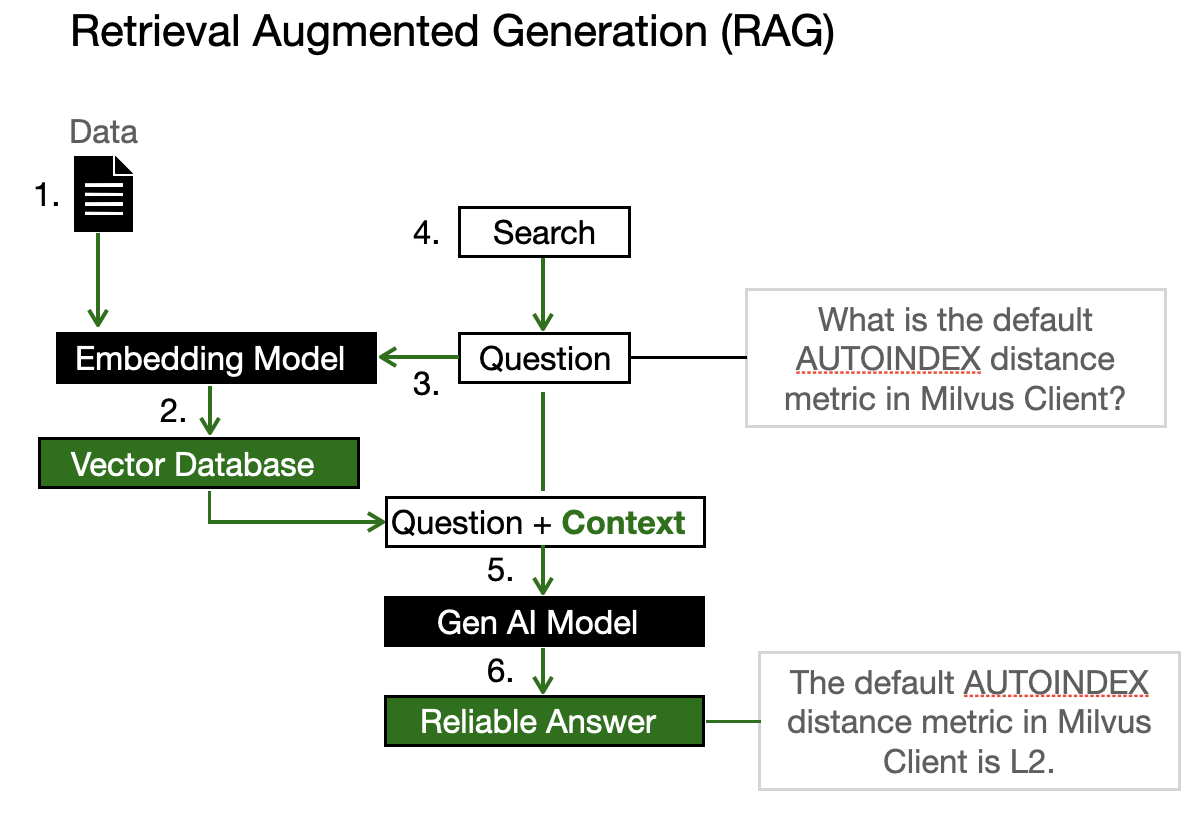

reference source code:
https://github.com/milvus-io/bootcamp/tree/master/bootcamp/RAG

In [2]:
# For colab install these libraries in this order:
!python -m pip install torch transformers sentence-transformers langchain

In [3]:
!python -m pip install -U pymilvus 'pymilvus[model]'

In [4]:
!python -m pip install unstructured openai tqdm numpy ipykernel

In [5]:
# Import common libraries.
import sys, os, time, pprint
import numpy as np

## Step 1: Prep Data for Vector Database Embedding

In [6]:
!pip install langchain-community langchain-core

In [7]:
from langchain_community.document_loaders import RecursiveUrlLoader, WebBaseLoader

#relevant data regarding Fingerhut credit card offering
DOCS_PAGE=[
    "https://www.fingerhut.com/content/footer-terms",
    "https://www.fingerhut.com/content/CreditTC?pageName=CreditTC",
    "https://www.fingerhut.com/content/faqs-fetti",
    "https://www.fingerhut.com/content/faqs-payments-balance-account-info"
]

loader = WebBaseLoader(DOCS_PAGE)
docs = loader.load()

num_documents = len(docs)
print(f"loaded {num_documents} documents")


loaded 4 documents


## Step 2: Set up Milvus
There are several ways of running Milvus:

1.   local Docker (recommended)
2.   Zilliz free tier
3.   from Colab (https://milvus.io/docs/quickstart.md)

 Milvus Lite, a python library included in pymilvus that can be embedded into the client application. Milvus also supports deployment on Docker and Kubenetes for production use cases


In [1]:
!pip install -U pymilvus

## Step 3: Load the Embedding Model

An excellent place to start is by selecting an embedding model from the HuggingFace MTEB Leaderboard(https://huggingface.co/spaces/mteb/leaderboard), sorted descending by the "Retrieval Average'' column since this task is most relevant to RAG. Then, choose the smallest, highest-ranking embedding model. But, Beware!! some models listed are overfit to the training data, so they won't perform on your data as promised.

In this notebook, we will use the open-source **BGE-M3** which supports:<br>
over 100 languages <br>
context lengths of up to 8192 <br>
multiple embedding inferences such as dense (semantic), sparse (lexical), and multi-vector Colbert reranking.<br>
BGE-M3 holds the distinction of being the first embedding model to offer support for all three retrieval methods, achieving state-of-the-art performance on multi-lingual (MIRACL) and cross-lingual (MKQA) benchmark tests.

Embedding function supported by Milvus:<br>
https://github.com/milvus-io/bootcamp/blob/master/bootcamp/model/embedding_functions.ipynb

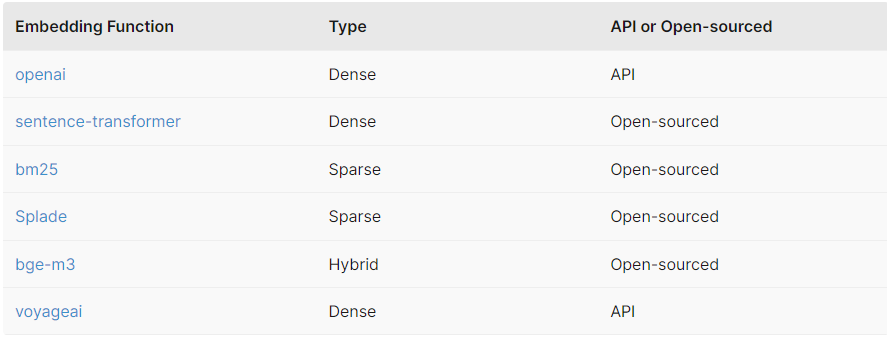

In [ ]:
#open AI embedding function

# from pymilvus import model

# # initialize using 'text-embedding-3-large'
# openai_ef = model.dense.OpenAIEmbeddingFunction(
#     model_name="text-embedding-3-large", # Specify the model name
#     dimensions=512 # Set the embedding dimensionality according to MRL feature.
# )

# # get the embeddings in general way.
# queries = docs
# queries_embeddings = openai_ef(queries)
# docs_embeddings = openai_ef(docs)

# # get the embeddings in specified way.
# queries_embeddings = openai_ef.encode_queries(queries)
# docs_embeddings = openai_ef.encode_documents(docs)

# # now we can check the dimension of embedding from results and the embedding function.
# print("dense dim:", openai_ef.dim, queries_embeddings[0].shape)
# print("dense dim:", openai_ef.dim, docs_embeddings[0].shape)

In [ ]:
# please set the use_fp16 to False when you are using cpu.
# by default the return options is:
#  return_dense True
#  return_sparse True
#  return_colbert_vecs False
# bge_m3_ef = BGEM3EmbeddingFunction(
#     model_name='BAAI/bge-m3', # Specify the model name
#     device='cpu', # Specify the device to use, e.g., 'cpu' or 'cuda:0'
#     use_fp16=False # Specify whether to use fp16. Set to `False` if `device` is `cpu`.
# )

CUDA® is a parallel computing platform and programming model developed by NVIDIA for general computing on graphical processing units (GPUs).

In [12]:
#compatible issue
#(grpcio 1.64.0 (/usr/local/lib/python3.10/dist-packages) -->Google Colab environment, Requirement.parse('grpcio<=1.63.0,>=1.49.1'), {'pymilvus'})
#error debug: https://github.com/deepset-ai/haystack/issues/1351
!pip install grpcio==1.63.0
!pip install grpcio-tools==1.63.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.0 which is incompatible.
google-ai-generativelanguage 0.6.4 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.27.0 which is incompatible.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 5.27.0 which is incompatible.
google-cloud-aiplatfo

In [9]:
torch.cuda.is_available()

False

In [8]:
#download embedding model

from pymilvus.model.hybrid import BGEM3EmbeddingFunction
import torch

# Initialize torch settings
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {DEVICE}")

# Initialize a Milvus built-in sparse-dense-reranking encoder.
# https://huggingface.co/BAAI/bge-m3
embedding_model = BGEM3EmbeddingFunction(use_fp16=False, device=DEVICE)
EMBEDDING_DIM = embedding_model.dim['dense']
print(f"dense_dim: {EMBEDDING_DIM}")
print(f"sparse_dim: {embedding_model.dim['sparse']}")
print(f"colbert_dim: {embedding_model.dim['colbert_vecs']}")

device: cpu
start to install package: FlagEmbedding>=1.2.2
successfully installed package: FlagEmbedding>=1.2.2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

imgs/bm25.jpg:   0%|          | 0.00/69.0k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

imgs/.DS_Store:   0%|          | 0.00/6.15k [00:00<?, ?B/s]

imgs/long.jpg:   0%|          | 0.00/485k [00:00<?, ?B/s]

colbert_linear.pt:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

imgs/miracl.jpg:   0%|          | 0.00/448k [00:00<?, ?B/s]

imgs/nqa.jpg:   0%|          | 0.00/158k [00:00<?, ?B/s]

imgs/mkqa.jpg:   0%|          | 0.00/608k [00:00<?, ?B/s]

long.jpg:   0%|          | 0.00/127k [00:00<?, ?B/s]

imgs/others.webp:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

onnx/Constant_7_attr__value:   0%|          | 0.00/65.6k [00:00<?, ?B/s]

onnx/config.json:   0%|          | 0.00/698 [00:00<?, ?B/s]

onnx/special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

model.onnx_data:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

onnx/tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/725k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sparse_linear.pt:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

dense_dim: 1024
sparse_dim: 250002
colbert_dim: 1024


## Step 4: Create Milvus Collection - Embedding

The collection will contain the

**Schema** (or no-schema Milvus client).
💡 You'll need the vector EMBEDDING_DIM parameter from your embedding model. Typical values are: <br>
**1024 for sbert embedding models**<br>
**1536 for ada-002 OpenAI embedding models**<br>
**Vector index** for efficient vector search (https://www.youtube.com/watch?v=dN0lsF2cvm4)<br>
**Vector distance metric** for measuring nearest neighbor vectors<br>
**Consistency level** In Milvus, transactional consistency is possible; however, according to the CAP theorem, some latency must be sacrificed. 💡 Searching movie reviews is not mission-critical, so eventually consistent is fine here.

### **4.1 Add a Vector Index**
The vector index determines the vector search algorithm used to find the closest vectors in your data to the query a user submits.<br>

**Most of the vector index types supported by Milvus use approximate nearest neighbors search (ANNS) algorithms**. Compared with accurate retrieval, which is usually very time-consuming, the core idea of ANNS is no longer limited to returning the most accurate result, but only searching for neighbors of the target. ANNS improves retrieval efficiency by sacrificing accuracy within an acceptable range.<br>

**According to the implementation methods, the ANNS vector index can be divided into four categories:**<br>
**Tree-based index**<br>
**Graph-based index**<br>
**Hash-based index**<br>
**Quantization-based index**<br>

Most vector indexes use different sets of parameters depending on whether the database is:<br>

inserting vectors (creation mode) - vs -<br>
searching vectors (search mode)<br>

Indexing approach supported by Milvus.https://milvus.io/docs/index.md#floating

Besides a search algorithm, we also need to specify a **distance metric, that is, a definition of what is considered "close" in vector space.** In the cell below, the HNSW search index is chosen. Its possible distance metrics are one of:<br>

L2 - L2-norm<br>
IP - Dot-product<br>
COSINE - Angular distance<br>
💡 Most use cases work better with normalized embeddings, in which case L2 is useless (every vector has length=1) and IP and COSINE are the same. Only choose L2 if you plan to keep your embeddings unnormalized.

In [10]:
# STEP 3. CREATE A NO-SCHEMA Fingerhut COLLECTION AND DEFINE THE DATABASE INDEX.
# See docstrings for more information.
# https://github.com/milvus-io/pymilvus/blob/master/examples/hello_hybrid_sparse_dense.py

# from pymilvus import MilvusClient, Collection, FieldSchema, DataType, CollectionSchema, utility

# client = MilvusClient("credit_card.db")

# # Set the Milvus collection name.
# COLLECTION_NAME = "FingerhutCreditCard"

# # Specify the data schema for the new Collection.
# MAX_LENGTH = 65535
# fields = [
#     # Use auto generated id as primary key
#     FieldSchema(name="id", dtype=DataType.INT64,
#                 is_primary=True, auto_id=True, max_length=100),
#     FieldSchema(name="sparse_vector", dtype=DataType.SPARSE_FLOAT_VECTOR),
#     FieldSchema(name="dense_vector", dtype=DataType.FLOAT_VECTOR,
#                 dim=EMBEDDING_DIM),
#     FieldSchema(name="chunk", dtype=DataType.VARCHAR, max_length=MAX_LENGTH),
#     FieldSchema(name="source", dtype=DataType.VARCHAR, max_length=MAX_LENGTH),
#     FieldSchema(name="h1", dtype=DataType.VARCHAR, max_length=100),
#     FieldSchema(name="h2", dtype=DataType.VARCHAR, max_length=MAX_LENGTH),
# ]
# schema = CollectionSchema(fields, "")

# # Check if collection already exists, if so drop it.
# has = utility.has_collection(COLLECTION_NAME)
# if has:
#     drop_result = utility.drop_collection(COLLECTION_NAME)
#     print(f"Successfully dropped collection: `{COLLECTION_NAME}`")

# # Create the collection.
# schema = CollectionSchema(fields, "")
# # col = Collection(COLLECTION_NAME, schema, consistency_level="Eventually")

# col = client.create_collection(
#     collection_name=COLLECTION_NAME,
#     schema,
#     consistency_level=3)


# # Add custom HNSW search index to the collection. HNSW - Graph index (stochastic approximate search)
# # M = max number graph connections per layer. Large M = denser graph.
# # Choice of M: 4~64, larger M for larger data and larger embedding lengths.
# M = 16
# # efConstruction = num_candidate_nearest_neighbors per layer.
# # Use Rule of thumb: int. 8~512, efConstruction = M * 2.
# efConstruction = M * 2
# # Create the search index for local Milvus server.
# INDEX_PARAMS = dict({
#     'M': M,
#     "efConstruction": efConstruction })

# # Create indices for the vector fields.
# # The indices will pre-load data into memory for efficient search.
# sparse_index = {"index_type": "SPARSE_INVERTED_INDEX", "metric_type": "IP"}
# dense_index = {"index_type": "HNSW", "metric_type": "COSINE", "params": INDEX_PARAMS}
# col.create_index("sparse_vector", sparse_index)
# col.create_index("dense_vector", dense_index)
# col.load()

# print(f"Successfully created collection: `{COLLECTION_NAME}`")

In [11]:
#rewrite this in Milvus Lite SDK syntax
#https://milvus.io/api-reference/pymilvus/v2.4.x/MilvusClient/Collections/create_collection.md

from pymilvus import MilvusClient, Collection, FieldSchema, DataType, CollectionSchema, utility

client = MilvusClient("credit_card.db")

COLLECTION_NAME = "FingerhutCreditCard"

# 1. Create schema
schema = MilvusClient.create_schema(
    auto_id=True,
    enable_dynamic_field=False,
)

# 2. Add fields to schema
MAX_LENGTH = 65535
schema.add_field(field_name="id", datatype=DataType.INT64, is_primary=True, max_length=100)
schema.add_field(field_name="sparse_vector", datatype=DataType.SPARSE_FLOAT_VECTOR)
schema.add_field(field_name="dense_vector", datatype=DataType.FLOAT_VECTOR, dim=EMBEDDING_DIM)
schema.add_field(field_name="chunk", datatype=DataType.VARCHAR, max_length=MAX_LENGTH)
schema.add_field(field_name="source", datatype=DataType.VARCHAR, max_length=MAX_LENGTH),
schema.add_field(field_name="h1", datatype=DataType.VARCHAR, max_length=100),
schema.add_field(field_name="h2", datatype=DataType.VARCHAR, max_length=MAX_LENGTH),

# 3. Prepare index parameters
index_params = client.prepare_index_params()

# Add custom HNSW search index to the collection. HNSW - Graph index (stochastic approximate search)
# M = max number graph connections per layer. Large M = denser graph.
# Choice of M: 4~64, larger M for larger data and larger embedding lengths.
M = 16
# efConstruction = num_candidate_nearest_neighbors per layer.
# Use Rule of thumb: int. 8~512, efConstruction = M * 2.
efConstruction = M * 2
# Create the search index for local Milvus server.
DENSE_PARAMS = dict({
    'M': M,
    "efConstruction": efConstruction })

# 4. Add indexes
index_params.add_index(
    field_name="dense_vector",
    index_type="HNSW",
    metric_type="COSINE",
    params=DENSE_PARAMS
)

index_params.add_index(
    field_name="sparse_vector",
    index_type="SPARSE_INVERTED_INDEX",
    metric_type="IP"
    # params={"nlist": 1024}
)

# 5. Create a collection
client.create_collection(
    collection_name=COLLECTION_NAME,
    schema=schema
)

# 6. Create indexes
client.create_index(
    collection_name=COLLECTION_NAME,
    index_params=index_params
)

# 6. List indexes
client.list_indexes(collection_name=COLLECTION_NAME)

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: fbd8b5ec5e7d499594712c20da330e66
DEBUG:pymilvus.milvus_client.milvus_client:Successfully created collection: FingerhutCreditCard
DEBUG:pymilvus.milvus_client.milvus_client:Successfully created an index on collection: FingerhutCreditCard
DEBUG:pymilvus.milvus_client.milvus_client:Successfully created an index on collection: FingerhutCreditCard


['dense_vector', 'sparse_vector']

### **4.2 Chunking**

Before embedding, it is necessary to decide your chunk strategy, chunk size, and chunk overlap. In this demo, I will use: <br>

Strategy = Use markdown header hierarchies. Keep markdown sections together unless they are too long. <br>
Chunk size = Use the embedding model's parameter MAX_SEQ_LENGTH<br>
Overlap = Rule-of-thumb 10-15%<br>
Function =<br>
**Langchain's HTMLHeaderTextSplitter to split markdown sections**.<br>
**Langchain's RecursiveCharacterTextSplitter to split up long reviews recursively**.<br>
Notice below, each chunk is grounded with the document source page.
In addition, header titles are kept together with the chunk of markdown text.

In [12]:
# # STEP 4. PREPARE DATA: CHUNK AND EMBED

# !python -m pip install lxml
from langchain_community.document_transformers import BeautifulSoupTransformer
from langchain.text_splitter import HTMLHeaderTextSplitter, RecursiveCharacterTextSplitter

# Define chunk size 512 and overlap 10% chunk_size.
chunk_size = 512
chunk_overlap = np.round(chunk_size * 0.10, 0)
print(f"chunk_size: {chunk_size}, chunk_overlap: {chunk_overlap}")

# Define the headers to split on for the HTMLHeaderTextSplitter
headers_to_split_on = [
    ("h1", "Header 1"),
    ("h2", "Header 2"),
]
# Create an instance of the HTMLHeaderTextSplitter
html_splitter = HTMLHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

# Create an instance of the RecursiveCharacterTextSplitter
child_splitter = RecursiveCharacterTextSplitter(
    chunk_size = chunk_size,
    chunk_overlap = chunk_overlap,
    length_function = len,  # using built-in Python len function
)

# Split the HTML text using the HTMLHeaderTextSplitter.
start_time = time.time()
html_header_splits = []
for doc in docs: #docs are the loaded Fingerhut doc webpage content
    splits = html_splitter.split_text(doc.page_content)
    for split in splits:
        # Add the source URL and header values to the metadata
        metadata = {}
        new_text = split.page_content
        for header_name, metadata_header_name in headers_to_split_on:
            # Handle exception if h1 does not exist.
            try:
                header_value = new_text.split("¶ ")[0].strip()[:100]
                metadata[header_name] = header_value
            except:
                break
            # Handle exception if h2 does not exist.
            try:
                new_text = new_text.split("¶ ")[1].strip()[:50]
            except:
                break
        split.metadata = {
            **metadata,
            "source": doc.metadata["source"]
        }
        # Add the header to the text
        split.page_content = split.page_content
    html_header_splits.extend(splits)

    # # TODO - Uncomment to save each doc.page_content as a local html file under OUTPUT_DIR.
    # OUTPUT_DIR = "output"
    # # Set filename to first 50 characters of h1 header.
    # filename = doc.metadata["source"].split("/")[-1].split(".")[0][:50]
    # with open(f"{OUTPUT_DIR}/{filename}.html", "w") as f:
    #     f.write(doc.page_content)

# Split the documents further into smaller, recursive chunks.
chunks = child_splitter.split_documents(html_header_splits)

end_time = time.time()
print(f"chunking time: {end_time - start_time}")
print(f"docs: {len(docs)}, split into: {len(html_header_splits)}")
print(f"split into chunks: {len(chunks)}, type: list of {type(chunks[0])}")

# Inspect a chunk.
print()
print("Looking at a sample chunk...")
print(chunks[0].page_content[:100])
print(chunks[0].metadata)

# # TODO - Uncomment to print child splits with their associated header metadata for debugging.
# print()
# for child in chunks:
#     print(f"Content: {child.page_content}")
#     print(f"Metadata: {child.metadata}")
#     print()

chunk_size: 512, chunk_overlap: 51.0
chunking time: 0.06304550170898438
docs: 4, split into: 4
split into chunks: 217, type: list of <class 'langchain_core.documents.base.Document'>

Looking at a sample chunk...
Fingerhut Skip to main content California Consumer Privacy Act Close For California residents, by pr
{'h1': 'Fingerhut Skip to main content California Consumer Privacy Act Close For California residents, by pr', 'source': 'https://www.fingerhut.com/content/footer-terms'}


In [15]:
for i in range(10):
    print(chunks[i].page_content[:100])

Fingerhut Skip to main content California Consumer Privacy Act Close For California residents, by pr
Us FAQs Product Guides Product Recall Returns Hello! Sign In My Account Sign In New Customer? Regist
gestures. Not an access card Apply Today, Buy Today1 Build your credit history with us Low monthly p
cycle. We will not charge you any interest on purchases if you pay your entire balance by the due da
Fees Penalty Fees Late Fee Up to $41.00 Returned Payment Fee Up to $41.00 How We Will Calculate Your
Credit Programs for more details. This is the Agreement which covers your credit account (called you
provision. Arbitration replaces the right to go to court and the right to have a jury decide a dispu
your Account to purchase goods or services from Fingerhut or any merchant authorized to accept your 
a transaction is posted to your Account. In this Agreement, and in your monthly statements ("Stateme
(a) credit extended by WebBank to you or anyone you allow to use your Account; (b) interest

In [ ]:
# Clean up the metadata urls - why doing this step?
# for doc in chunks:
#     new_url = doc.metadata["source"]
#     new_url = new_url.replace("rtdocs", "https://milvus.io/docs")
#     new_url = new_url.replace(".html", ".md")
#     doc.metadata.update({"source": new_url})

# print(chunks[0].page_content[:100])
# print(chunks[0].metadata)

Use the built-in Milvus BGE M3 embedding functions. The output will be 2 vectors: <br>

embeddings['dense'][i] is a list of numpy arrays, one per chunk. Milvus supports more than 1 dense embedding vector if desired, so i is the ith dense embedding vector.<br>
embeddings['sparse'][:, [i]] is a scipy sparse matrix where each column represents a chunk.

### **4.3 Apply Embedding Model**

In [16]:
# TRANSFORM CHUNKS INTO VECTORS USING EMBEDDING MODEL INFERENCE.

# BGEM3EmbeddingFunction input is docs as a list of strings.
list_of_strings = [doc.page_content for doc in chunks if hasattr(doc, 'page_content')]

# Embedding inference using the Milvus built-in sparse-dense-reranking encoder.
start_time = time.time()
embeddings = embedding_model(list_of_strings)
end_time = time.time()

print(f"Embedding time for {len(list_of_strings)} chunks: ", end="")
print(f"{np.round(end_time - start_time, 2)} seconds")

Embedding time for 217 chunks: 351.72 seconds


In [17]:
embeddings['dense'][0]

array([-0.01989644, -0.01185617, -0.05253905, ..., -0.0169681 ,
       -0.02945183,  0.02479041], dtype=float32)

In [18]:
embeddings['sparse'][:, 0]

<217x1 sparse matrix of type '<class 'numpy.float32'>'
	with 0 stored elements in Compressed Sparse Row format>

### **4.4 Insert data (vector) into Milvus**

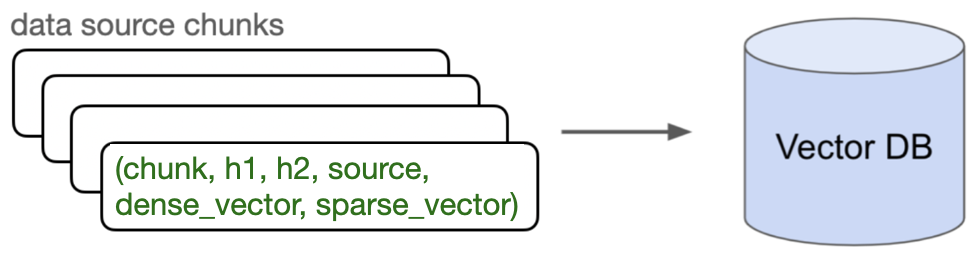

The Milvus Client wrapper can only handle loading data from a list of dictionaries.

Otherwise, in general, Milvus supports loading data from:

**pandas dataframes**<br>
**list of dictionaries**

In [19]:
# INSERT CHUNK LIST INTO MILVUS OR ZILLIZ.

# Create chunk_list and dict_list in a single loop
dict_list = []
for chunk, sparse, dense in zip(chunks, embeddings["sparse"], embeddings["dense"]):
    # Assemble embedding vector, original text chunk, metadata.
    chunk_dict = {
        'chunk': chunk.page_content,
        'h1': chunk.metadata.get('h1', "")[:50],
        'h2': chunk.metadata.get('h2', "")[:50],
        'source': chunk.metadata.get('source', ""),
        'sparse_vector': sparse,
        'dense_vector': dense
    }
    dict_list.append(chunk_dict)

# TODO - Uncomment to inspect the first chunk and its metadata.
print(len(dict_list))
print(type(dict_list[0]), len(dict_list[0]))
pprint.pprint(dict_list[0])

217
<class 'dict'> 6
{'chunk': 'Fingerhut Skip to main content California Consumer Privacy Act '
          'Close For California residents, by proceeding to interact with '
          'Fingerhut, please be aware that your personal information may be '
          'collected. To understand the types of personal information that we '
          'may collect about you, please visit our Privacy Page. Account Cart '
          'items Sign In New Customer? Register Now My Account Apply For '
          'Credit Account Overview Track My Order Wish List Customer Service '
          'Contact Us FAQs Product Guides Product Recall Returns',
 'dense_vector': array([-0.01989644, -0.01185617, -0.05253905, ..., -0.0169681 ,
       -0.02945183,  0.02479041], dtype=float32),
 'h1': 'Fingerhut Skip to main content California Consumer',
 'h2': '',
 'source': 'https://www.fingerhut.com/content/footer-terms',
 'sparse_vector': <1x250002 sparse matrix of type '<class 'numpy.float32'>'
	with 58 stored elements in 

In [24]:
# Insert data into the Milvus collection.
print("Start inserting entities")
start_time = time.time()
client.insert(
     collection_name=COLLECTION_NAME,
     data=dict_list)

end_time = time.time()
print(f"Milvus insert time for {len(dict_list)} vectors: ", end="")
print(f"{np.round(end_time - start_time, 2)} seconds")
# client.flush() #version 2.2

print(client.get_collection_stats(COLLECTION_NAME))

Start inserting entities
Milvus insert time for 217 vectors: 0.21 seconds
{'row_count': 651}


### **4.5 Test with Semantic Vector Search**

**Query** is the generic term for user questions.
A query is a list of multiple individual questions, up to maybe 1000 different questions! <br>
**Question** usually refers to a single user question.
In our example below, the user question is "What is AUTOINDEX in Milvus Client?"<br>
**Semantic Search** = very fast search of the entire knowledge base to find the TOP_K documentation chunks with the closest embeddings to the user's query.

In [26]:
# Define a sample question about your data.
QUESTION1 = "What is APR Fingerhut charge?"
QUESTION2 = "What if I make payment late?"
QUESTION3 = "What can I buy using the Fingerhut FreshStart® Credit Account issued by WebBank"

# In case you want to ask all the questions at once.
QUERY = [QUESTION1, QUESTION2, QUESTION3]

# Inspect the length of one question.
QUERY_LENGTH = len(QUESTION2)
print(f"query length: {QUERY_LENGTH}")

query length: 28


By their nature, vector searches are "semantic" searches. For example, if you were to search for "leaky faucet": <br>

**Traditional Key-word** Search - either or both words "leaky", "faucet" would have to match some text in order to return a web page or link text to the document.<br>

**Semantic search** - results containing words "drippy" "taps" would be returned as well because these words mean the same thing even though they are different words.

In [29]:
SAMPLE_QUESTION = QUESTION3

In [63]:
from pymilvus import connections
connections.connect()

MilvusException: <MilvusException: (code=2, message=Fail connecting to server on localhost:19530, illegal connection params or server unavailable)>

In [61]:
from pymilvus import AnnSearchRequest, RRFRanker, WeightedRanker

# Load the index into memory for search.
client.load_collection(
    collection_name=COLLECTION_NAME,
    replica_number=2
)
# Embed the question using the same encoder.
query_embeddings = embedding_model([SAMPLE_QUESTION])
TOP_K = 3

# Return top k results with HNSW index.
SEARCH_PARAMS = dict({
    # Re-use index param for num_candidate_nearest_neighbors.
    "ef": DENSE_PARAMS['efConstruction']
    })

# Prepare the search requests for both vector fields
sparse_search_params = {"metric_type": "IP"}
sparse_req = AnnSearchRequest(
                query_embeddings["sparse"],
                "sparse_vector", sparse_search_params, limit=TOP_K)

dense_search_params = {"metric_type": "COSINE"}
dense_search_params.update(SEARCH_PARAMS)
dense_req = AnnSearchRequest(
                query_embeddings["dense"],
                "dense_vector", dense_search_params, limit=TOP_K)

# Define output fields to return.
OUTPUT_FIELDS = ["id", "h1", "h2", "source", "chunk"]

# Run semantic vector search using your query and the vector database.
start_time = time.time()
# Use the reranker.
results = client.hybrid_search(
            collection_name=COLLECTION_NAME,
            data=[sparse_req, dense_req],
            rerank=RRFRanker(),
            limit=TOP_K,
            output_fields=OUTPUT_FIELDS)
# # No reranking.
# results = col.hybrid_search([
#             sparse_req, dense_req], rerank=WeightedRanker(0.5, 0.5),
#             limit=TOP_K, output_fields=OUTPUT_FIELDS)

elapsed_time = time.time() - start_time
print(f"Milvus Client search time for {len(dict_list)} vectors: {elapsed_time} seconds")

# Inspect search result.
print(f"type: {type(results[0])}, count: {len(results[0])}")

# Currently Milvus only support 1 query in the same hybrid search request, so
# we inspect res[0] directly. In future release Milvus will accept batch
# hybrid search queries in the same call.
results = results[0]

# Milvus Client search time for 304 vectors: 0.02100086212158203 seconds
# type: <class 'pymilvus.client.abstract.Hits'>, count: 2

ERROR:pymilvus.decorators:RPC error: [search], <MilvusException: (code=1100, message=multiple anns_fields exist, please specify a anns_field insearch_params: invalid parameter)>, <Time:{'RPC start': '2024-06-03 23:38:48.628500', 'RPC error': '2024-06-03 23:38:48.634139'}>
ERROR:pymilvus.milvus_client.milvus_client:Failed to search collection: FingerhutCreditCard


MilvusException: <MilvusException: (code=1100, message=multiple anns_fields exist, please specify a anns_field insearch_params: invalid parameter)>